# Project Phase 1 
## SimBoost


#### Name: ثنا آیرملو
#### Student No.: 96101284

Drug discovery is a time-consuming, laborious, costly and high-risk process. According to a report by the Eastern Research Group (ERG), it usually takes 10-15 years to develop a new drug. However, the success rate of developing a new molecular entity is only 2.01%. \
Finding a compound that selectively binds to a particular protein is a highly challenging and typically expensive procedure in the drug development process. \
In this project we are going to implement [SimBoost](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5395521/#CR42) which is machine-learning approch for predicting drug–target binding affinities using gradient boosting.




We will be using [Davis](http://staff.cs.utu.fi/~aatapa/data/DrugTarget/) dataset, which contains selectivity assays of the kinase protein family and the relevant inhibitors with their respective dissociation constant (Kd) values. It comprises interactions of 442 proteins and 68 drugs.

## 1. Setup (15 Points)

### 1.1 Imports libs

In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### 1.2 Loading data

We need following files for this project:
- `target_gene_names.txt`: gene names of the targets
- `drug_PubChem_CIDs.txt`: PubChem CIDs of the drugs
- `drug-drug_similarities_2D.txt`: drug-drug structural fingerprint similarities computed the Structure Clustering sever at PubChem
- `target-target_similarities_WS_normalized.txt`: target-target sequence similarities computed with the normalized versions of the Smith-Waterman (SW) score.
- `drug-target_interaction_affinities_Kd__Davis_et_al.2011.txt`: drug-target interaction affinities.

The rows (and columns) of the drug-drug similarity matrices correspond to the rows of the interaction affinity matrix and the rows (and columns) of the target-target similarity matrices correspond to the columns of the interaction affinity matrix.

In [108]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
target_gene_names = pd.read_csv("/content/drive/My Drive/ML_BIO_Project_Phase1_StudentVersion/target_gene_names.txt", header=None, index_col = 0)
drug_pubchemIDs = pd.read_csv("/content/drive/My Drive/ML_BIO_Project_Phase1_StudentVersion/drug_PubChem_CIDs.txt", header=None, index_col = 0) #  dtype=str
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# Load each file using pd.read_csv and use target_gene_names and drug_pubchemIDs
# to correspond row index and columns of all three files.
# sim_targets.shape == (442, 442)
# sim_drugs.shape == (68, 68)
# bindings.shape == (68, 442)
# Note that target_gene_names and drug_pubchemIDs dataframes are empty, we are
# going to fill them with features.
#################################################################################
bindings = pd.read_csv('/content/drive/My Drive/ML_BIO_Project_Phase1_StudentVersion/drug-target_interaction_affinities_Kd__Davis_et_al.2011.txt',sep = ' ',header = None)
bindings.index = drug_pubchemIDs.index.values
bindings.columns =  target_gene_names.index.values
sim_drugs = pd.read_csv('/content/drive/My Drive/ML_BIO_Project_Phase1_StudentVersion/drug-drug_similarities_2D.txt',sep = ' ',header = None)
sim_drugs.index = drug_pubchemIDs.index.values
sim_drugs.columns =  drug_pubchemIDs.index.values
sim_targets = pd.read_csv('/content/drive/My Drive/ML_BIO_Project_Phase1_StudentVersion/target-target_similarities_WS_normalized.txt',sep = ' ',header = None)
sim_targets.index = target_gene_names.index.values
sim_targets.columns =  target_gene_names.index.values
# #################################################################################
# #                                   THE END                                     #
# #################################################################################
sim_targets.shape, sim_drugs.shape, bindings.shape,target_gene_names.shape,drug_pubchemIDs.shape

((442, 442), (68, 68), (68, 442), (442, 0), (68, 0))

### 1.3 Preprocessing

In davis dataset, standard value is Kd in nM. we used the transformation below:

### $pK_{d}=-log_{10}\frac{K_d}{1e9}$ 


In [110]:
drug_pubchemIDs.sort_index(inplace=True)
target_gene_names.sort_index(inplace=True)
target_gene_names.head()
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# sort sim_targets, sim_drugs, bindings based on their index like above 
# divide all values of sim_targets by 100
# transform binding values as mentioned above
#################################################################################
sim_targets.sort_index(inplace=True)
sim_drugs.sort_index(inplace=True)
bindings.sort_index(inplace=True)
sim_targets = sim_targets/100
transformed_bindings = -1*np.log10(bindings/1e+09)

#################################################################################
#                                   THE END                                     #
#################################################################################
transformed_bindings.head()

,AAK1,ABL1(E255K)-phosphorylated,ABL1(F317I)-nonphosphorylated,ABL1(F317I)-phosphorylated,ABL1(F317L)-nonphosphorylated,ABL1(F317L)-phosphorylated,ABL1(H396P)-nonphosphorylated,ABL1(H396P)-phosphorylated,ABL1(M351T)-phosphorylated,ABL1(Q252H)-nonphosphorylated,ABL1(Q252H)-phosphorylated,ABL1(T315I)-nonphosphorylated,ABL1(T315I)-phosphorylated,ABL1(Y253F)-phosphorylated,ABL1-nonphosphorylated,ABL1-phosphorylated,ABL2,ACVR1,ACVR1B,ACVR2A,ACVR2B,ACVRL1,ADCK3,ADCK4,AKT1,AKT2,AKT3,ALK,AMPK-alpha1,AMPK-alpha2,ANKK1,ARK5,ASK1,ASK2,AURKA,AURKB,AURKC,AXL,BIKE,BLK,...,TAOK2,TAOK3,TBK1,TEC,TESK1,TGFBR1,TGFBR2,TIE1,TIE2,TLK1,TLK2,TNIK,TNK1,TNK2,TNNI3K,TRKA,TRKB,TRKC,TRPM6,TSSK1B,TTK,TXK,TYK2(JH1domain-catalytic),TYK2(JH2domain-pseudokinase),TYRO3,ULK1,ULK2,ULK3,VEGFR2,VRK2,WEE1,WEE2,YANK1,YANK2,YANK3,YES,YSK1,YSK4,ZAK,ZAP70
5291,5.000000,6.769551,8.080922,6.236572,8.602060,6.958607,8.229148,7.187087,7.356547,8.744727,7.036212,5.000000,5.000000,6.886057,8.958607,7.677781,8.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.0,5.0,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.283997,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.366532,5.000000,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,5.000000,5.060481,5.000000,5.000000,5.000000,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.585027,5.000000
44259,8.920819,7.657577,6.259637,6.886057,6.769551,7.337242,7.744727,7.443697,7.283997,7.677781,7.958607,8.075721,8.537602,7.638272,7.431798,7.657577,6.958607,6.327902,6.167491,5.05061,5.337242,5.000000,5.0,5.0,7.698970,7.356547,6.769551,7.494850,8.431798,7.920819,6.568636,8.356547,6.958607,6.585027,7.769551,7.721246,7.638272,8.167491,8.251812,7.823909,...,7.920819,9.657577,9.050610,5.886057,6.494850,5.698970,5.000000,7.187087,6.853872,7.568636,7.79588,8.327902,8.602060,7.795880,6.000000,8.397940,8.420216,7.769551,5.0,7.619789,7.214670,6.638272,7.251812,5.508638,6.552842,8.004365,9.102373,8.920819,6.657577,5.0,5.795880,5.000000,7.886057,7.008774,6.508638,7.283997,6.958607,9.065502,5.000000,7.356547
123631,5.000000,6.397940,5.000000,5.327902,5.568636,6.107905,6.167491,6.337242,6.283997,5.958607,6.638272,5.000000,5.000000,6.443697,5.657577,6.318759,5.795880,5.000000,5.000000,5.00000,5.000000,5.000000,5.0,5.0,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.744727,5.000000,5.920819,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,5.161151,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.0,5.000000,5.000000,5.221849,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.619789,5.000000,5.000000
126565,8.508638,6.075721,5.000000,5.309804,5.119186,5.657577,6.000000,6.060481,6.107905,5.602060,6.080922,6.022276,6.795880,6.040959,5.494850,6.000000,5.187087,7.124939,7.065502,5.60206,5.420216,5.657577,5.0,5.0,5.356547,5.677781,5.207608,7.148742,7.602060,7.251812,7.494850,8.431798,7.154902,6.769551,7.795880,7.795880,8.387216,7.455932,7.795880,6.795880,...,6.301030,7.065502,7.744727,5.920819,6.537602,6.920819,6.267606,6.167491,6.200659,6.958607,7.19382,8.267606,8.031517,8.180456,5.677781,8.080922,7.853872,7.853872,5.0,7.008774,8.187087,6.180456,7.823909,6.040959,6.187087,6.000000,7.221849,8.309804,6.657577,5.0,5.920819,5.102373,5.677781,5.229148,5.096910,6.795880,7.013228,9.283997,5.173925,7.795880
151194,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.0,5.0,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000

(array([22754.,  2400.,  1869.,  1189.,   799.,   528.,   297.,   150.,
           47.,    23.]),
 array([ 5.        ,  5.579588  ,  6.159176  ,  6.73876401,  7.31835201,
         7.89794001,  8.47752801,  9.05711601,  9.63670401, 10.21629202,
        10.79588002]),
 <a list of 10 Patch objects>)

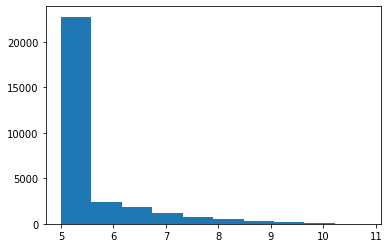

In [111]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# Plot histogram of all values in transformed_bindings
# Hint: use .stack and .plot.hist  
#################################################################################
import matplotlib.pyplot
matplotlib.pyplot.hist(transformed_bindings.stack())

#################################################################################
#                                   THE END                                     #
#################################################################################

As you can see in histogram. The peak at pKd value 5 (10000 nM), These values correspond to the negative pairs that either have very weak binding affinities (Kd > 10000nM) or are not observed in the primary screen.

### 1.4 Drug-Target-Binding

In [112]:
import pandas as pd
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# use drug_target_binding and build drug_target_binding dataframe 
# in each row of dataframe you must have one drug-target pair and their 
# transformed binding value, in the end you must have a dataframe with 
# 30056 row and 3 columns ['Drug', 'Target', 'Binding_Val']
#################################################################################
drug_target_binding = pd.DataFrame(columns =['Target', 'Drug', 'Binding_Val'] )
for i in range(transformed_bindings.shape[0]):
    for j in range(transformed_bindings.shape[1]):
        drug_target_binding.loc[len(drug_target_binding)]= [transformed_bindings.columns.values[j],transformed_bindings.index.values[i],transformed_bindings.values[i][j]]


# #################################################################################
# #                                   THE END                                     #
# #################################################################################
drug_target_binding.head()

,Target,Drug,Binding_Val
0,AAK1,5291,5.000000
1,ABL1(E255K)-phosphorylated,5291,6.769551
2,ABL1(F317I)-nonphosphorylated,5291,8.080922
3,ABL1(F317I)-phosphorylated,5291,6.236572
4,ABL1(F317L)-nonphosphorylated,5291,8.602060


In [113]:
drug_target_binding.shape

(30056, 3)

### 1.5 Train, Validation and Test Datasets

In [114]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# split drug_target_binding dataframe to 3 sets (train_data, val_data, test_data)
# split ratio is up to you
# at the end you must have 3 sets that each of them has 3 columns
#################################################################################

train_data, test_data = train_test_split(drug_target_binding, test_size=0.2)
train_data, val_data = train_test_split(train_data, test_size=0.2)


# train_data = None
# val_data = None
# test_data = None

#################################################################################
#                                   THE END                                     #
#################################################################################
train_data.shape, val_data.shape, test_data.shape

((19235, 3), (4809, 3), (6012, 3))

## 2.Feature Engineering (35 Points)

In this part we are going to extract some feature for each target/drug. after that we will replace these features with their names/pubchemIDs. 

### 2.1 Average Similarities and Binding values

In [115]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# for each target compute their average similarities in sim_targets matrix
# and average binding value (in train_data).
# add these two feature as 'avg-sim', 'avg-binding' to target_gene_names DataFrame
#################################################################################
target_gene_names['avg-sim']= [None for i in range(len(target_gene_names))]
target_gene_names['avg-binding']= [None for i in range(len(target_gene_names))]
for i in target_gene_names.index.values:
    target_gene_names['avg-sim'][i] = sum(sim_targets.loc[:,i])/len(sim_targets.loc[:,i])

for i in range(len(train_data)):
    if target_gene_names['avg-binding'][train_data['Target'].values[i]]  == None:
        target_gene_names['avg-binding'][train_data['Target'].values[i]] = [train_data['Binding_Val'].values[i],1]
    else:
        n = (target_gene_names['avg-binding'][train_data['Target'].values[i]])[1]+1
        v = (target_gene_names['avg-binding'][train_data['Target'].values[i]])[0]+ train_data['Binding_Val'].values[i]
        target_gene_names['avg-binding'][train_data['Target'].values[i]] = [v,n]
for i in range(len(target_gene_names)):
    x = target_gene_names['avg-binding'].values[i][0]/target_gene_names['avg-binding'].values[i][1]
    target_gene_names['avg-binding'].values[i] = x

#################################################################################
#                                   THE END                                     #
#################################################################################
target_gene_names.head()

,avg-sim,avg-binding
0,,
AAK1,0.479173,5.78214
ABL1(E255K)-phosphorylated,0.535796,6.19113
ABL1(F317I)-nonphosphorylated,0.535796,5.61405
ABL1(F317I)-phosphorylated,0.535796,5.8005
ABL1(F317L)-nonphosphorylated,0.535796,5.8252


In [116]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# for each drug compute their average similarities in sim_drugs matrix
# and average binding value (in train_data).
# add these two feature as 'avg-sim', 'avg-binding' to drug_pubchemIDs DataFrame
#################################################################################
drug_pubchemIDs['avg-sim']= [None for i in range(len(drug_pubchemIDs))]
drug_pubchemIDs['avg-binding']= [None for i in range(len(drug_pubchemIDs))]
for i in drug_pubchemIDs.index.values:
    drug_pubchemIDs['avg-sim'][i] = sum(sim_drugs.loc[i,:])/len(sim_drugs.loc[i,:])

for i in range(len(train_data)):
    if drug_pubchemIDs['avg-binding'][train_data['Drug'].values[i]]  == None:
        drug_pubchemIDs['avg-binding'][train_data['Drug'].values[i]] = [train_data['Binding_Val'].values[i],1]
    else:
        n = (drug_pubchemIDs['avg-binding'][train_data['Drug'].values[i]])[1]+1
        v = (drug_pubchemIDs['avg-binding'][train_data['Drug'].values[i]])[0]+ train_data['Binding_Val'].values[i]
        drug_pubchemIDs['avg-binding'][train_data['Drug'].values[i]] = [v,n]
for i in range(len(drug_pubchemIDs)):
    x = drug_pubchemIDs['avg-binding'].values[i][0]/drug_pubchemIDs['avg-binding'].values[i][1]
    drug_pubchemIDs['avg-binding'].values[i] = x


#################################################################################
#                                   THE END                                     #
#################################################################################
drug_pubchemIDs.head()

,avg-sim,avg-binding
0,,
5291,0.615412,5.24149
44259,0.559441,7.16751
123631,0.608265,5.25381
126565,0.530206,6.74776
151194,0.558706,5.06789


### 2.2 Drug/Target Similarity Networks

#### 2.2.1 Build Networks

You must build two networks one for drugs and another one for targets. The nodes are drugs or targets, and an edge between two nodes exists if their similarity is above a threshold. The value of threshold is up to you. \
For building networks, we are going to use [igraph](https://igraph.org/) package. 

In [117]:
!apt-get install libcairo2-dev 
!pip install pycairo

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcairo2-dev is already the newest version (1.15.10-2ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [118]:
! pip3 install python-igraph
# import igraph

In [0]:
import igraph

In [0]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# define drug_sim_threshold, target_sim_threshold and use these values to
# build two network one for drugs and another one for targets using sim_drugs
# and sim_targets.
# Hint: you can use igraph.Graph.Adjacency, you can plot your graph using 
# igraph.plot
#################################################################################
drug_sim_threshold = 0.7 ##################################################################################################################################################################
target_sim_threshold = 0.5 ##################################################################################################################################################################
labels_drugs = sim_drugs.index.values
adjac_drugs = [[0 for i in range(len(labels_drugs))]for i in range(len(labels_drugs))]
for i in range(len(labels_drugs)):
    for j in range(len(labels_drugs)):
        if i != j:
            if sim_drugs[labels_drugs[i]][labels_drugs[j]]>drug_sim_threshold:
                adjac_drugs[i][j] = 1

labels_targets = sim_targets.index.values
adjac_targets = [[0 for i in range(len(labels_targets))]for i in range(len(labels_targets))]
for i in range(len(labels_targets)):
    for j in range(len(labels_targets)):
        if i != j:
            if sim_targets[labels_targets[i]][labels_targets[j]]>target_sim_threshold:
                adjac_targets[i][j] = 1
drug_graph = igraph.Graph.Adjacency(adjac_drugs).as_undirected()
target_graph = igraph.Graph.Adjacency(adjac_targets).as_undirected()
#################################################################################
#                                   THE END                                     #
#################################################################################

In [0]:
drug_graph.vs['label'] = labels_drugs
target_graph.vs['label'] = sim_targets.index.values

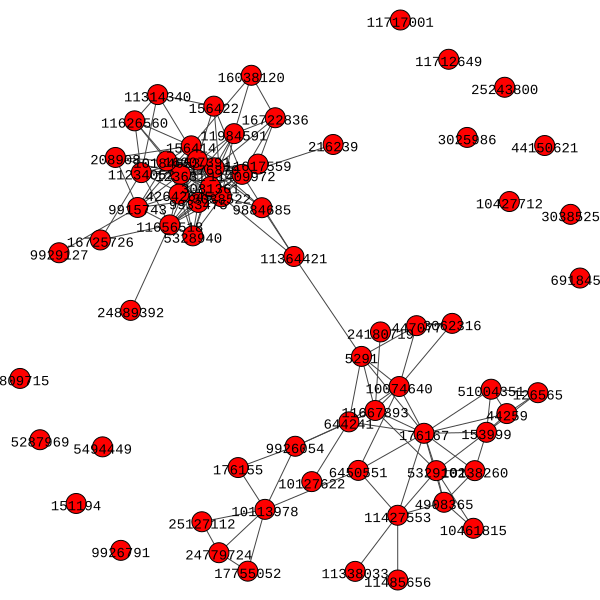

In [122]:
igraph.plot(drug_graph)

In [123]:
igraph.plot(target_graph)

Output hidden; open in https://colab.research.google.com to view.

Explain how you choose your threshold values? \
ابتدا target_sim_threshold را ثابت  گرفتم و به ارای مقادیر  مختلف آن که دقت  بهتری داشت را به عنوان drug_sim_threshold گرفتم. همین کار را برای  دیگری هم کردم.


#### 2.2.2 Number of neighbors, PageRank

In [124]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# for each drug compute number of neighbors and it's PageRank score. 
# add these two feature as 'n_neighbors', 'page_rank' to drug_pubchemIDs DataFrame.
# do the above for each target too and add them to target_gene_names DataFrame.
# Hint: for pagerank score you can use graph.pagerank.
#################################################################################
target_gene_names['n_neighbors']= target_graph.degree()
drug_pubchemIDs['n_neighbors'] = drug_graph.degree()

target_gene_names['page_rank']= target_graph.pagerank()
drug_pubchemIDs['page_rank'] = drug_graph.pagerank()

#################################################################################
#                                   THE END                                     #
#################################################################################
target_gene_names.head()

,avg-sim,avg-binding,n_neighbors,page_rank
0,,,,
AAK1,0.479173,5.78214,104,0.001239
ABL1(E255K)-phosphorylated,0.535796,6.19113,229,0.002278
ABL1(F317I)-nonphosphorylated,0.535796,5.61405,229,0.002278
ABL1(F317I)-phosphorylated,0.535796,5.8005,229,0.002278
ABL1(F317L)-nonphosphorylated,0.535796,5.8252,229,0.002278


### 2.3 Non-negative Matrix Factorization

For extracting features from binding affinity matrix we are going to use [Non-negative Matrix Factorization](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization). 

In NMF, we are trying to approximately factor a matrix $B ∈ R_+^{d×t}$ (binding affinity matrix of d drugs and t targets) into two matrices $P ∈ R_+^{k×d}$ and $Q ∈ R_+^{k×t}$ which  $B = P^TQ$

In this problem, you can set $k$ (Latent dimension of $P$ and $Q$ matrices) to any number below 10.


The columns of the factor matrices P and Q are utilized as parts of the feature vectors for the drugs and targets respectively.

In [0]:
from sklearn.decomposition import NMF

In [126]:
print(len(drug_pubchemIDs),len(target_gene_names))
train_data.head()

68 442


,Target,Drug,Binding_Val
15258,MAPKAPK2,10074640,5.000000
3653,EGFR(L747-S752del P753S),176155,5.795880
2870,LYN,156414,6.091515
27482,CHEK2,24889392,5.000000
21534,PIK3CB,11617559,5.000000


In [127]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# define latent_dim variable, after that use train_data to build bindings matrix
# because we remove some of the bindings values when we choose train_data in part 1.5  
# your matrix will have some na values fill them with 5 (Which is lowest binding score).
#################################################################################
latent_dim = 3
train_binding_m = [[5.00000 for i  in range(len(target_gene_names))]for j in  range(len(drug_pubchemIDs))]
train_binding_matrix = pd.DataFrame(train_binding_m)
train_binding_matrix.columns = target_gene_names.index.values
train_binding_matrix.index =  drug_pubchemIDs.index.values

for i in train_data.values:
    drug = i[0]
    target = i[1]
    v = i[2]
    train_binding_matrix[drug][target] = v
    
#################################################################################
#                                   THE END                                     #
#################################################################################
train_binding_matrix.head()

,AAK1,ABL1(E255K)-phosphorylated,ABL1(F317I)-nonphosphorylated,ABL1(F317I)-phosphorylated,ABL1(F317L)-nonphosphorylated,ABL1(F317L)-phosphorylated,ABL1(H396P)-nonphosphorylated,ABL1(H396P)-phosphorylated,ABL1(M351T)-phosphorylated,ABL1(Q252H)-nonphosphorylated,ABL1(Q252H)-phosphorylated,ABL1(T315I)-nonphosphorylated,ABL1(T315I)-phosphorylated,ABL1(Y253F)-phosphorylated,ABL1-nonphosphorylated,ABL1-phosphorylated,ABL2,ACVR1,ACVR1B,ACVR2A,ACVR2B,ACVRL1,ADCK3,ADCK4,AKT1,AKT2,AKT3,ALK,AMPK-alpha1,AMPK-alpha2,ANKK1,ARK5,ASK1,ASK2,AURKA,AURKB,AURKC,AXL,BIKE,BLK,...,TESK1,TGFBR1,TGFBR2,TIE1,TIE2,TLK1,TLK2,TNIK,TNK1,TNK2,TNNI3K,TRKA,TRKB,TRKC,TRPM6,TSSK1B,TTK,TXK,TYK2(JH1domain-catalytic),TYK2(JH2domain-pseudokinase),TYRO3,ULK1,ULK2,ULK3,VEGFR2,VRK2,WEE1,WEE2,YANK1,YANK2,YANK3,YES,YSK1,YSK4,ZAK,ZAP70,p38-alpha,p38-beta,p38-delta,p38-gamma
5291,5.000000,5.00000,8.080922,6.236572,8.602060,6.958607,8.229148,7.187087,7.356547,8.744727,7.036212,5.0,5.00000,6.886057,8.958607,7.677781,8.000000,5.000000,5.000000,5.00000,5.0,5.000000,5.0,5.0,5.000000,5.0,5.000000,5.00000,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,5.000000,5.000000,5.0,5.000000,5.000000,6.283997,...,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,5.0,5.0,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,5.0,5.060481,5.000000,5.0,5.000000,5.0,5.000000,5.0,5.000000,5.0,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.0,5.000000,5.0,5.0,5.000000,5.000000
44259,8.920819,5.00000,6.259637,6.886057,5.000000,5.000000,7.744727,5.000000,7.283997,5.000000,7.958607,5.0,5.00000,7.638272,7.431798,7.657577,5.000000,6.327902,6.167491,5.05061,5.0,5.000000,5.0,5.0,7.698970,5.0,5.000000,7.49485,8.431798,7.920819,5.0,8.356547,5.000000,5.000000,7.769551,7.721246,5.0,8.167491,8.251812,5.000000,...,5.000000,5.698970,5.0,7.187087,6.853872,5.000000,5.0,5.0,8.602060,7.795880,6.0,5.000000,8.420216,5.000000,5.0,7.619789,7.214670,6.638272,5.0,5.508638,6.552842,5.0,9.102373,5.0,5.000000,5.0,5.795880,5.0,7.886057,7.008774,6.508638,7.283997,6.958607,5.000000,5.0,7.356547,5.0,5.0,5.000000,7.376751
123631,5.000000,6.39794,5.000000,5.327902,5.000000,5.000000,6.167491,5.000000,6.283997,5.958607,5.000000,5.0,5.00000,5.000000,5.657577,6.318759,5.795880,5.000000,5.000000,5.00000,5.0,5.000000,5.0,5.0,5.000000,5.0,5.000000,5.00000,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,5.000000,5.000000,5.0,5.744727,5.000000,5.920819,...,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,5.0,5.0,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,5.0,5.000000,5.000000,5.221849,5.0,5.000000,5.000000,5.0,5.000000,5.0,5.000000,5.0,5.000000,5.0,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.0,5.000000,5.0,5.0,5.000000,5.000000
126565,8.508638,5.00000,5.000000,5.000000,5.119186,5.000000,6.000000,5.000000,6.107905,5.602060,5.000000,5.0,6.79588,6.040959,5.494850,6.000000,5.187087,5.000000,7.065502,5.00000,5.0,5.657577,5.0,5.0,5.356547,5.0,5.207608,5.00000,7.602060,7.251812,5.0,8.431798,7.154902,6.769551,7.795880,5.000000,5.0,7.455932,7.795880,6.795880,...,6.537602,6.920819,5.0,6.167491,6.200659,6.958607,5.0,5.0,8.031517,8.180456,5.0,8.080922,7.853872,7.853872,5.0,7.008774,8.187087,6.180456,5.0,6.040959,5.000000,6.0,7.221849,5.0,6.657577,5.0,5.920819,5.0,5.000000,5.229148,5.000000,6.795880,7.013228,9.283997,5.0,5.000000,5.0,5.0,5.455932,6.431798
151194,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.0,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,5.0,5.000000,5.0,5.0,5.000000,5.0,5.000000,5.00000,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,5.0,5.0,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,5.0,5.000000,5.000000,5.0,5.000000,5.0,5.000000,5.0,5.000000,5.0,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.0,5.000000,5.0,5.0,5.000000,5.000000


In [0]:
model = NMF(n_components=latent_dim)
W = model.fit_transform(train_binding_matrix.values)

In [129]:
H = model.components_
print(H)

[[1.36565564 1.20769522 1.25902188 ... 1.35581582 1.33049844 1.30171437]
 [0.         1.38190924 0.74688064 ... 0.45518899 0.2587543  0.26603015]
 [0.82822754 0.11404615 0.33004985 ... 0.15703853 0.22813404 0.41952401]]


In [130]:
Ht = np.transpose(H)
print(W.shape,H.shape,Ht.shape)

(68, 3) (3, 442) (442, 3)


In [131]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# Use sklearn NMF and factor 'train_binding_matrix' to P and Q.
# add columns of P and Q as features to 'drug_pubchemIDs' and 'target_gene_names'
#################################################################################
drug_pubchemIDs['features']= [None for i in range(len(drug_pubchemIDs))]
target_gene_names['features']= [None for i in range(len(target_gene_names))]
for i in range(len(W)):
        drug_pubchemIDs['features'][train_binding_matrix.index[i]] = W[i]
Ht = np.transpose(H)        
for i in range(len(Ht)):
        target_gene_names['features'][train_binding_matrix.columns[i]] = Ht[i]



#################################################################################
#                                   THE END                                     #
#################################################################################
target_gene_names.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,avg-sim,avg-binding,n_neighbors,page_rank,features
0,,,,,
AAK1,0.479173,5.78214,104,0.001239,"[1.3656556380530578, 0.0, 0.8282275443773335]"
ABL1(E255K)-phosphorylated,0.535796,6.19113,229,0.002278,"[1.207695216554975, 1.3819092361316656, 0.1140..."
ABL1(F317I)-nonphosphorylated,0.535796,5.61405,229,0.002278,"[1.259021882171338, 0.7468806411433719, 0.3300..."
ABL1(F317I)-phosphorylated,0.535796,5.8005,229,0.002278,"[1.2420587420269693, 1.071639782513312, 0.1220..."
ABL1(F317L)-nonphosphorylated,0.535796,5.8252,229,0.002278,"[1.2601508695065604, 1.0328932852930048, 0.122..."


In [132]:
drug_pubchemIDs.head()

,avg-sim,avg-binding,n_neighbors,page_rank,features
0,,,,,
5291,0.615412,5.24149,6,0.021949,"[3.2313407787006176, 1.7314825992643956, 0.657..."
44259,0.559441,7.16751,4,0.015751,"[3.3697756292963383, 0.0, 4.851198005704661]"
123631,0.608265,5.25381,17,0.033830,"[3.5709101522423556, 0.9299908035955051, 0.244..."
126565,0.530206,6.74776,3,0.012508,"[3.579900241699337, 0.0, 3.3417466001204734]"
151194,0.558706,5.06789,0,0.002634,"[3.3225046009980197, 0.8941749716769682, 0.804..."


### 2.4 Building Train, Validation and Test Dataset using extracted features

In [133]:
train_data.head()

,Target,Drug,Binding_Val
15258,MAPKAPK2,10074640,5.000000
3653,EGFR(L747-S752del P753S),176155,5.795880
2870,LYN,156414,6.091515
27482,CHEK2,24889392,5.000000
21534,PIK3CB,11617559,5.000000


In [134]:
val_data.head()

,Target,Drug,Binding_Val
15799,PKAC-alpha,10113978,5.0
19513,CDK2,11364421,5.0
21486,NDR1,11617559,5.0
8056,DCAMKL2,3062316,5.0
29756,ERK2,51004351,5.0


In [135]:
test_data.head(10)

,Target,Drug,Binding_Val
24041,GSK3A,11984591,5.602060
16478,EIF2AK1,10138260,5.000000
8690,PAK6,3081361,5.000000
1244,RIOK2,123631,5.000000
7593,CIT,3038525,5.000000
21157,SGK3,11485656,5.721246
14231,CSNK1A1L,9929127,5.000000
26867,PRKG1,24180719,5.000000
3364,NDR1,156422,5.000000
16493,ERBB3,10138260,5.000000


In [136]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# Replace drug pubchemID and Target gene name with extracted features.
# and build X (drug and target features) and Y (binding_values) for each dataset
# (Train, Validation, Test)
#################################################################################

X_train = np.zeros([len(train_data.values),2*latent_dim+4])
Y_train = np.zeros(len(train_data.values))
n = 0
for v in train_data.values:
    x = np.concatenate((drug_pubchemIDs['features'][v[1]],[drug_pubchemIDs['n_neighbors'][v[1]]],[drug_pubchemIDs['page_rank'][v[1]]],
                        target_gene_names['features'][v[0]],[target_gene_names['n_neighbors'][v[0]]],[target_gene_names['n_neighbors'][v[0]]]))
    for j in range(len(x)):
        X_train[n][j] = x[j]
    Y_train[n] = v[2]
    n += 1
  # print(X_train.shape)
  # print(X_train)

X_val = np.zeros([len(val_data.values),2*latent_dim+4])
Y_val = np.zeros(len(val_data.values))
n = 0
for v in val_data.values:
    x = np.concatenate((drug_pubchemIDs['features'][v[1]],[drug_pubchemIDs['n_neighbors'][v[1]]],[drug_pubchemIDs['page_rank'][v[1]]],
                        target_gene_names['features'][v[0]],[target_gene_names['n_neighbors'][v[0]]],[target_gene_names['n_neighbors'][v[0]]]))
    for j in range(len(x)):
        X_val[n][j] = x[j]
    Y_val[n] = v[2]
    n += 1

X_test = np.zeros([len(test_data.values),2*latent_dim+4])
Y_test = np.zeros(len(test_data.values))
n = 0
for v in test_data.values:
    x = np.concatenate((drug_pubchemIDs['features'][v[1]],[drug_pubchemIDs['n_neighbors'][v[1]]],[drug_pubchemIDs['page_rank'][v[1]]],
                        target_gene_names['features'][v[0]],[target_gene_names['n_neighbors'][v[0]]],[target_gene_names['n_neighbors'][v[0]]]))
    for j in range(len(x)):
        X_test[n][j] = x[j]
    Y_test[n] = v[2]
    n += 1



#################################################################################
#                                   THE END                                     #
#################################################################################
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((19235, 10), (19235,), (4809, 10), (4809,), (6012, 10), (6012,))

## 3.XGboost (25 Points)

To predict the continuous binding affinity for drug–target pairs, we will use [XGBoost](https://xgboost.readthedocs.io/en/latest/) library. 

You need to tune following hyperparameters:
- `learning_rate`: Boosting learning rate
- `n_estimators`: Number of gradient boosted trees.
- `max_depth `: Maximum tree depth for base learners.
- `colsample_bytree`: Subsample ratio of columns when constructing each tree.
- `subsample`: Subsample ratio of the training instance.




Note: `drug_sim_threshold`, `target_sim_threshold` and `latent_dim` in Feature Engineering part can be viewed as hyperparameters too.

In [0]:
import xgboost
from sklearn.metrics import mean_squared_error

### 3.1 Tune Hyperparameters

In [0]:
def plot_model_results(results):
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
    ax.plot(x_axis, results['validation_1']['rmse'], label='Validation')
    ax.legend()
    plt.ylabel('RMSE')
    plt.show()

[13:16:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation RMSE: 42.742


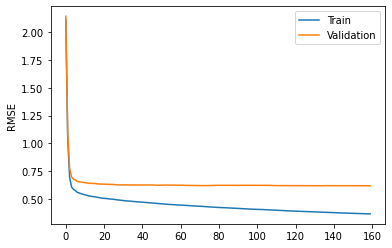

In [139]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# Tune hyperparameters values and train model using .fit with Train data
# you can use l1 and l2 regularization terms too
# after training calculate Root Mean Square Error (RMSE) for validation data
#################################################################################
import math
learning_rate = 0.6
n_estimators = 160
max_depth = 5
colsample_bytree = 0.9
subsample = 0.9

model = xgboost.XGBRegressor(objective ='reg:linear', learning_rate = learning_rate, 
                             colsample_bytree = colsample_bytree,
                             max_depth = max_depth, 
                             subsample = subsample, 
                             n_estimators = n_estimators,
                             eval_metric='rmse')

model.fit(X_train,Y_train, eval_metric="rmse", 
          eval_set=[(X_train, Y_train), (X_val, Y_val)],
          verbose=False)


validation_rmse = math.sqrt(sum(np.power((model.predict(X_val)-Y_val),2)))
#################################################################################
#                                   THE END                                     #
#################################################################################
print("Validation RMSE: %.3f" % validation_rmse)
plot_model_results(model.evals_result())

### 3.2 Ploting Feature importance

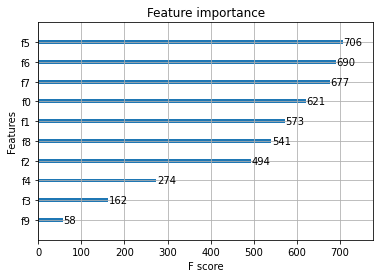

In [140]:
xgboost.plot_importance(model);

### 3.2 Evaluation

Let's make our perdiction binary. either a drug is binded to target or not, use $pK_d$ > 7 threshold as binded (drug-target) pair.

In [141]:
from sklearn.metrics import confusion_matrix
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# Calculate RMSE for Test data. after that
# Calculate accuracy, precision, recall, f1-score for X_test
# for binary prediction setting. you can use confution_matrix from sklearn
#################################################################################
p = model.predict(X_test)
test_rmse = math.sqrt(sum(np.power((p-Y_test),2)))
cm = confusion_matrix(Y_test>7, p>7)
print(cm)
test_acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[1][1]+cm[1][0]+cm[0][1])
test_percision = (cm[1][1])/(cm[1][1]+cm[0][1])
test_recall = (cm[1][1])/(cm[1][1]+cm[1][0])
test_f1 =  2*(test_recall * test_percision) / (test_recall + test_percision)


#################################################################################
#                                   THE END                                     #
#################################################################################
print("Test RMSE: %.3f" % test_rmse)
print("Test Accuracy: %.3f" % test_acc)
print("Test Percision: %.3f" % test_percision)
print("Test Recall: %.3f" % test_recall)
print("Test F1-Score: %.3f" % test_f1)

[[5473   65]
 [ 272  202]]
Test RMSE: 46.120
Test Accuracy: 0.944
Test Percision: 0.757
Test Recall: 0.426
Test F1-Score: 0.545


## 4.Classification (25 Points)

Change Binding values to binary values with threshold $pK_d$ > 7 
and use X_train to train any Classifier method that you like.\
Report `accuracy`, `precision`, `recall`, `f1-score` for X_test. 



In [144]:
from sklearn.ensemble import RandomForestClassifier
Y_test_binary = []
Y_train_binary = []
for y in Y_test:
  if y > 7:
    Y_test_binary.append(1)
  else:
    Y_test_binary.append(-1)
for y in Y_train:
  if y > 7:
    Y_train_binary.append(1)
  else:
    Y_train_binary.append(-1)
clf = RandomForestClassifier(n_estimators=80)
clf.fit(X_train, Y_train_binary)
p = clf.predict(X_test)
cm = confusion_matrix(Y_test_binary, p)
test_acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[1][1]+cm[1][0]+cm[0][1])
test_percision = (cm[1][1])/(cm[1][1]+cm[0][1])
test_recall = (cm[1][1])/(cm[1][1]+cm[1][0])
test_f1 =  2*(test_recall * test_percision) / (test_recall + test_percision)

print("Test Accuracy: %.3f" % test_acc)
print("Test Percision: %.3f" % test_percision)
print("Test Recall: %.3f" % test_recall)
print("Test F1-Score: %.3f" % test_f1)

Test Accuracy: 0.940
Test Percision: 0.736
Test Recall: 0.382
Test F1-Score: 0.503


# Extra Points

There is 5 extra points in parts 3 & 4 rewarded to the top 15% students with the best results. Your model will be trained again with a random seed on our dataset. Please have in mind:
- You should only use train or validation data for training phase of your model.
- Your code must be readable and runnable in other enviroments.
- If you are going to use other libraries, mention them.